In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import joblib
import time
from pathlib import Path

sns.set_style('darkgrid')
data_folder = Path('../data')

In [148]:
df_final_test = pd.read_csv(data_folder / 'test_data_100_clients.csv')
df = pd.read_csv(data_folder / 'train_test_data.csv')
df.rename(columns = {'is_movie_package_subscriber':'is_vod_subscriber', 'reamining_contract':'remaining_contract'}, inplace = True)

In [28]:
df_orig = pd.read_csv(data_folder / 'internet_service_churn.csv')
df_orig

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
72269,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1
72270,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1
72271,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1
72272,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1


##### Розділемо датасет на 2 частини:  
* одна для фінального тстування та завантаження в Streamlit - випадкові 100 рядків 
* друга (без попередніх рядків) буде використовуватися для аналізу та тренування моделей
  
Виправимо назви колонок.

In [5]:
df_final_test = df_orig.sample(n=100, random_state=42)
df = df_orig.drop(df_final_test.index)
df.to_csv(data_folder / 'train_test_data.csv', index=False)
df_final_test.to_csv(data_folder / 'test_data_100_clients.csv', index=False)

df.rename(columns = {'is_movie_package_subscriber':'is_vod_subscriber', 'reamining_contract':'remaining_contract'}, inplace = True)

In [149]:
df.shape

(72074, 11)

##### Загальна інформація  по датасету

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72074 entries, 0 to 72073
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     72074 non-null  int64  
 1   is_tv_subscriber       72074 non-null  int64  
 2   is_vod_subscriber      72074 non-null  int64  
 3   subscription_age       72074 non-null  float64
 4   bill_avg               72074 non-null  int64  
 5   remaining_contract     50597 non-null  float64
 6   service_failure_count  72074 non-null  int64  
 7   download_avg           71699 non-null  float64
 8   upload_avg             71699 non-null  float64
 9   download_over_limit    72074 non-null  int64  
 10  churn                  72074 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.0 MB


Бачимо що в деякіх колонках відсутні значення.   
5 ствбчик, та 7 і 8 стовбчики  - містить NaN значення.

Подивимось на іх кількість

In [151]:
df.isna().sum()

id                           0
is_tv_subscriber             0
is_vod_subscriber            0
subscription_age             0
bill_avg                     0
remaining_contract       21477
service_failure_count        0
download_avg               375
upload_avg                 375
download_over_limit          0
churn                        0
dtype: int64

Кількість значень NaN в стовбчиках 'download_avg' та 'upload_avg' становить менш ніж 0,5% від усіх значень.  
Видалимо  рядки з NaN значеннями - це не вплине суттєво на  загальні данні 

In [152]:
df.dropna(subset=['download_avg', 'upload_avg'], inplace=True, ignore_index=True)

##### Перевіримо данні на наявність дублікатів

In [153]:
print(df.iloc[:, 1:-1].duplicated(keep='first').sum())
print(df_final_test.iloc[:, 1:-1].duplicated(keep='first').sum())

1941
0


In [154]:
df= df.drop_duplicates(subset=df.iloc[:, 1:-1])
df.shape

(69758, 11)

##### Проведемо аналіз данних в 5 стовбчику  
У опису до датасету на Kaggle написано: "how many year remaining for customer contract. if null; customer hasnt have a contract. the customer who has a contract time have to use their service until contract end."  
Колонка містить значення: <b>Non-zero, 0, NaN</b>  
<b>NaN</b> - клієнт не має контракту  
<b>Non-zero</b> - контрактний клієнт  
<b>0</b> - незрозуміло , спробуємо розібратись.  
Побудуємо діаграмму:

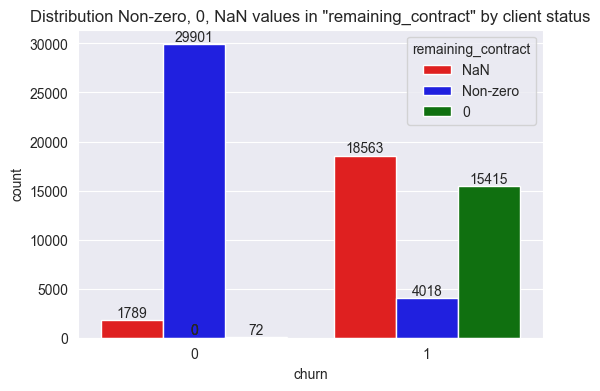

In [155]:
df_results = df['remaining_contract'].apply(lambda x: '0' if x == 0 else ('NaN' if pd.isna(x) else 'Non-zero'))
f,ax = plt.subplots(figsize=(6,4))
sns.countplot(hue=df_results, x='churn', data=df, palette=['r', 'b', 'g'], ax=ax)
plt.title('Distribution Non-zero, 0, NaN values in "remaining_contract" by client status')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

Бачимо що є лише 72 <b>активних</b> клієнта в яких 'reamining_contract' == 0, та 15415 клієнт які відмовились від послуг.  
Можна припустити що 0 означає що <b>контракт закінчився</b>.  
Таким чином маємо: 
* 15415 клієнта які не продовжили контракт та пішли   
* 72 клієнта в яких контракт закінчується сьогодні, тобто на момент генерації початкових данних

Подивимось також скількі клієнтів мають менше місяця до завршення контракту

In [156]:
cond = (df['remaining_contract']>=0)&(df['remaining_contract']<0.1)&(df['churn']==0)
df[cond]['id'].count()

1533

Вважаю що для тренування моделі цілком розумно буде зробити наступне:  
Вибрати всіх <b>активних</b> клієнтів, у яких контракт закінчується через певний проміжок часу (~1 місяць) та змінити їх статус на <b>втрачений</b>.  
Таким чином ми змусимо модель <b>заздалегіть</b> виявляти потенційно втрачених клієнтів. 

In [157]:
df.loc[cond, 'churn'] = 1

Перевіримо - так, ці всі клієнти переведені у "втрачені"

In [158]:
df[(df['churn']==0)&(df['remaining_contract']>=0)&(df['remaining_contract']<0.1)]['id'].count()

0

Додамо новий стовбчик 'contract', в якому позначимо - мав\має клієнт контракт (1) чи ні (0).  
Можна сказати, що ми додали нову feature для дослідження та прогнозування.

In [159]:
df['contract'] = df['remaining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)
df.insert(5, 'contract', df.pop('contract'))
df['remaining_contract'] = df['remaining_contract'].fillna(0)

##### Датасет виглядяє наступним чином:

In [164]:
df[['id', 'contract', 'remaining_contract', 'churn']].sample(n=10, random_state=43)

,id,contract,remaining_contract,churn
44462,1047250,1,0.00,1
66022,1552344,1,1.72,0
27665,653267,0,0.00,0
55051,1294976,1,0.00,1
37336,880180,1,0.28,0
28015,661045,0,0.00,1
54763,1287969,1,0.01,1
19054,449591,1,0.00,1
32535,768433,0,0.00,1
52524,1237190,1,0.10,0


<class 'pandas.core.frame.DataFrame'>
Index: 69758 entries, 0 to 71698
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     69758 non-null  int64  
 1   is_tv_subscriber       69758 non-null  int64  
 2   is_vod_subscriber      69758 non-null  int64  
 3   subscription_age       69758 non-null  float64
 4   bill_avg               69758 non-null  int64  
 5   contract               69758 non-null  int64  
 6   remaining_contract     69758 non-null  float64
 7   service_failure_count  69758 non-null  int64  
 8   download_avg           69758 non-null  float64
 9   upload_avg             69758 non-null  float64
 10  download_over_limit    69758 non-null  int64  
 11  churn                  69758 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 6.9 MB
None


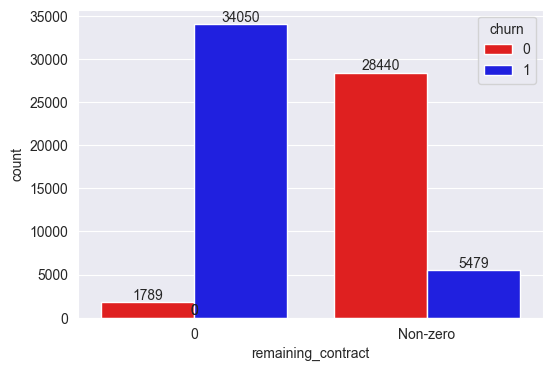

In [165]:
print(df.info())

df_results = df['remaining_contract'].apply(lambda x: '0' if x == 0 else  'Non-zero')
f,ax = plt.subplots(figsize=(6,4))
sns.countplot(x=df_results, hue='churn', data=df, palette=['r', 'b'], ax=ax)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

##### Подивимось на статистичні данні

In [166]:
df.iloc[:, 1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,69758.0,0.825081,0.379901,0.00,1.00,1.00,1.00,1.00
is_vod_subscriber,69758.0,0.340233,0.473791,0.00,0.00,0.00,1.00,1.00
subscription_age,69758.0,2.476921,2.024732,-0.02,0.95,1.98,3.36,12.80
bill_avg,69758.0,19.256458,13.168920,0.00,13.00,19.00,23.00,406.00
contract,69758.0,0.708249,0.454572,0.00,0.00,1.00,1.00,1.00
remaining_contract,69758.0,0.511486,0.669651,0.00,0.00,0.00,1.05,2.92
service_failure_count,69758.0,0.282821,0.828389,0.00,0.00,0.00,0.00,19.00
download_avg,69758.0,44.924258,63.826646,0.00,8.30,29.20,61.80,4415.20
upload_avg,69758.0,4.310382,9.926757,0.00,0.60,2.20,5.00,453.30
download_over_limit,69758.0,0.208406,0.998718,0.00,0.00,0.00,0.00,7.00


##### Бачимо що:
* is_tv_subscriber - послугу IPTV  підключали більше 75% клієнтів
* subscription_age - 75% клієнтів компанії були підключені за останні 3 роки 
* bill_avg - 75% клієнтів компанії платять менше 23$
* reamining_contract - треба дослідити  

##### Подивимось більш детально. Виділимо ативних та неактивних клієнтів

In [167]:
alive = df[df['churn'] == 0]
die = df[df['churn'] == 1]

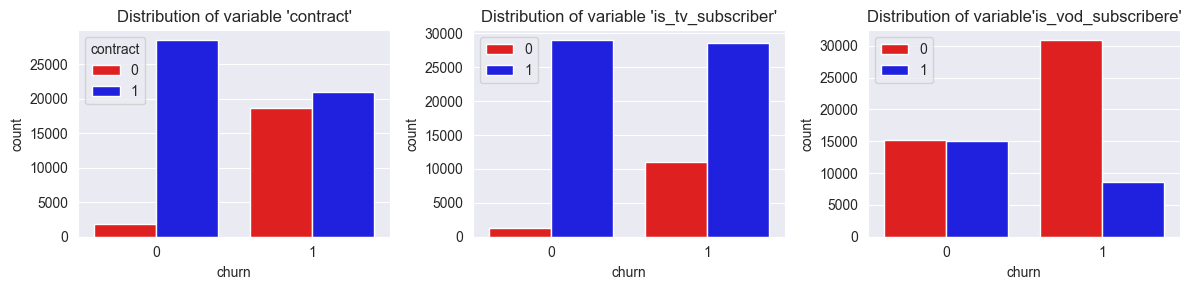

In [168]:
f, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.countplot(x='churn', hue='contract', data=df, ax=axs[0], palette=['r','b'])
axs[0].set_title("Distribution of variable 'contract'")

sns.countplot(x='churn', hue='is_tv_subscriber', data=df, ax=axs[1], palette=['r','b'])
axs[1].set_title("Distribution of variable 'is_tv_subscriber'")
axs[1].legend(loc="upper left")

sns.countplot(x='churn', hue='is_vod_subscriber', data=df, ax=axs[2], palette=['r','b'])
axs[2].set_title("Distribution of variable'is_vod_subscribere'")
axs[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

##### По графікам можна побачити:
1. Майже всі активні клієнти мають контракт, а в неактивних в половини його не було.
2. Більшість активних клієнтів підключені до послуг IPTV
3. Половина активних клієнтів мають доступ до відеотеки

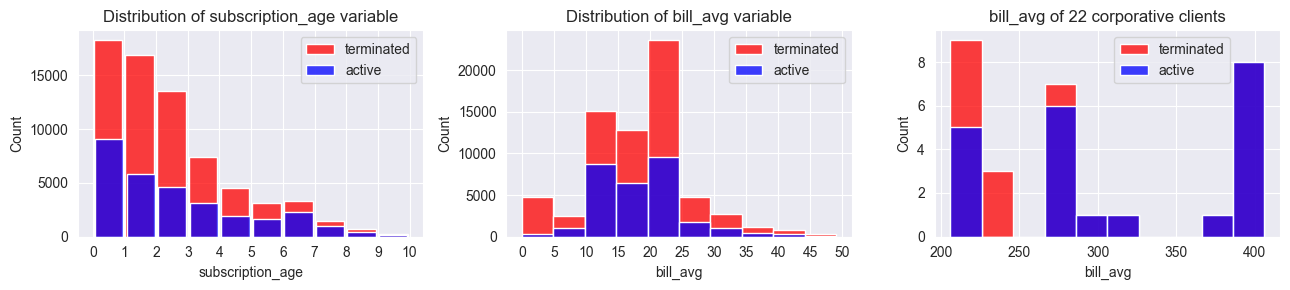

In [169]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))

sns.histplot(df[df['subscription_age']<10]['subscription_age'], bins=10, color='r', ax=axs[0], shrink=0.9, label='terminated')
sns.histplot(alive[alive['subscription_age']<10]['subscription_age'], bins=10, color='b', ax=axs[0], shrink=0.9, label='active')
axs[0].set_xticks(np.arange(0, 11, 1))
axs[0].set_title("Distribution of subscription_age variable")
axs[0].legend(loc="upper right")

sns.histplot(df[df['bill_avg'] < 50]['bill_avg'], bins=10, color='r', ax=axs[1], label='terminated')
sns.histplot(alive[alive['bill_avg'] < 50]['bill_avg'], bins=10, color='b', ax=axs[1], label='active')
axs[1].set_xticks(np.arange(0, 51, 5))
axs[1].set_title("Distribution of bill_avg variable")
axs[1].legend(loc="upper right")


corp_client = len(alive[alive['bill_avg'] >= 200]['bill_avg'])
sns.histplot(df[df['bill_avg'] >= 200]['bill_avg'], bins=10, color='r', ax=axs[2], label='terminated')
sns.histplot(alive[alive['bill_avg'] >= 200]['bill_avg'], bins=10, color='b', ax=axs[2], label='active')
axs[2].set_title(f"bill_avg of {corp_client} corporative clients")
axs[2].legend(loc="best", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

plt.tight_layout()
plt.show()

##### По графікам можна побачити:
1.  За останні 2 роки поступово зменшувалась кількість нових клієнтів. До цього спостерігався значний приріст.  
Червоним позначено клієнтів які починали працювати {subscription_age} років назад і припинили користування
2.  Більшість клієнтів (~55 000) сплачують в середньому від 10 до 25 $ за послуги, з них 26 000 активних
3.  З цікавого - компанія має 22 клієнти які сплачують більше 200$, скоріш за все це корпоративні клієнти  

##### Подивимось як корелюють ознаки(features) та цільова ознака(target)

In [170]:
# styles = [dict(selector="th", props=[('width', '40px')]),
#             dict(selector="th.col_heading",
#                 props=[("writing-mode", "vertical-rl"),
#                         ('transform', 'rotateZ(180deg)'),
#                         ('vertical-align', 'middle'),
#                         ('text-align', 'left')
#                         ])]
# df_corr_styled = df_corr.set_table_styles(styles)

df_corr = df.iloc[:, 1:].corr().iloc[:-1,-1:].style.format("{:.2}")
df_corr.background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1, vmin=-1, vmax=1)

,churn
is_tv_subscriber,-0.31
is_vod_subscriber,-0.29
subscription_age,-0.092
bill_avg,-0.0025
contract,-0.45
remaining_contract,-0.71
service_failure_count,0.025
download_avg,-0.27
upload_avg,-0.15
download_over_limit,0.15


Бачимо що ознаки "contract" та "remaining_contract" мають найбільшу кореляцю з цільовою ознакою.  
Вона від'ємна, тобто при зменшенні значення  однієї ознаки інша зростає.  
Скоріш за все вони будуть найважливіші при прогнозуванні.

##### По цим данним можна стверджувати що:
* чим менше часу до закінчення контракту [--> 0] тим БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]
* якщо нема підписаного контракту [0] то БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]
* чим менше вхідна швидкість мережі [--> 0] тим БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]
* якщо в клієнта немає підписки на IPTV чи відеотеку тим БІЛЬШЕ вірогідність того що клієнт відмовиться від послуг [1]  

Цікаво що довготривалість підиски (subscription_age) не дуже впливає на рішення клієнта припинити користування

----

##### Виділимо features та target

In [172]:
y = df['churn']
X = df.drop(columns=['churn','id'])

##### Подивимось на збалансованість данних

In [173]:
print(y.value_counts())

churn
1    39529
0    30229
Name: count, dtype: int64


##### Розділемо данні на тренувальну та тестову вибірки.  
Враховуючи що є незбалансованість вирішено примінити oversample метод  SMOTE(Synthetic Minority Oversampling Technique)  
Для стандартизації данних будемо використовувати метод StandardScaler

In [234]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.unique(y_train, return_counts=True))

(array([0, 1], dtype=int64), array([24171, 31635], dtype=int64))


In [175]:
scaler = StandardScaler()
oversample = SMOTE()
scaler.fit(x_train)

StandardScaler()

In [176]:
X_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, y_train)
X_train_scaled_oversampled = scaler.transform(X_train_oversampled)
X_test_scaled = scaler.transform(x_test)

X_train = X_train_scaled_oversampled
X_test = X_test_scaled
y_train = y_train_oversampled

print(np.unique(y_train, return_counts=True))

(array([0, 1], dtype=int64), array([31635, 31635], dtype=int64))


In [232]:
X_train_scaled = scaler.transform(x_train)
X_test_scaled = scaler.transform(x_test)

Бачимо що тепер кількість данних для обох класів в тренувальній вибірці однакова

In [178]:
print('train X', X_train.shape)
print('train y', y_train.shape)
print('test X', X_test.shape)
print('test y', y_test.shape)

train X (63270, 10)
train y (63270,)
test X (13952, 10)
test y (13952,)


Збережемо SCALER в файл для можливості подальшого використання

In [181]:
joblib.dump(scaler,'../scalers/scaler_Serhii.pkl')

['../scalers/scaler_1_Serhii.pkl']

----

## Побудова моделей  
Наша задача - спрогнозувати потенційно втраченого клієнта, тобто 1  
Якщо модель спрогнозує 1 а клієнт насправді 0, то для нас це не критично.  
Але, якщо модель спрогнозує 0 замість 1, то це бде критична помилка та втрата клієнта.  
Тому при тренуванні спробуємо вказати, щоб модель більш точно прогнозувала саме 1, тобто втрату клієнта.  
вкажемо це за допомогою:  <b>'class_weight': [{0:0.3, 1:0.7}]</b>
https://scikit-learn.org/1.5/modules/svm.html#unbalanced-problems  
таким чином зменшуючи вагу 0 класу, ми даємо можливсть моделі більш точно передбачити клас 1.

Для оцінки точності моделі будемо використовувати точність прогнозування класу 1

In [182]:
recall_1 = make_scorer(recall_score, pos_label=1)

##### Функція аналізу роботи моделей

In [183]:
def model_info(y_test, y_pred):
    precision1 = precision_score(y_test, y_pred, pos_label=1)*100
    recall = recall_score(y_test, y_pred, pos_label=1)*100
    print(f'Модель прогнозує 1 у {precision1:.2f}% випадках')
    print(f'На тестувальних данних правильно {recall:.2f}%  класу 1')
    print('\n','-'*50)
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    print('\n','-'*50)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=900, vmax=6000)
    plt.title('Confusion matrix')
    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.show()

Підбирати найкращі гіперпараметри будемо за допомогою GridSearchCV

### Logistic regression

In [ ]:
LR = LogisticRegression()
param_grid = {'penalty':[None, 'l1', 'l2'],
              'C': [10, 1, 0,1, 0.01], 
              'max_iter':[10, 50, 100, 200], 
              'solver': ['lbfgs', 'liblinear'],
              'class_weight': [{0:0.3, 1:0.7}, {0:0.6, 1:0.4}]
              }

logisticRegression = GridSearchCV(LR, param_grid, cv = 2, scoring=recall_1, verbose=0, n_jobs=-1)
logisticRegression.fit(X_train, y_train)

lr_model = logisticRegression.best_estimator_

lr_start_time = time.time()
lr_model.fit(X_train, y_train)
lr_end_time = time.time()-lr_start_time

y_pred_lr = lr_model.predict(X_test)
recall_lr = recall_score(y_test, y_pred_lr, pos_label=1)
precision_lr = precision_score(y_test, y_pred_lr, pos_label=1)

##### Найкращі параметри для LogisticRegression та час тренування моделі

In [185]:
print(f'Build Logistic Regression model time: {lr_end_time:.2f} secs')
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

Build Logistic Regression model time: 0.12 secs
Logistic Regression best parameters: {'C': 0.01, 'class_weight': {0: 0.3, 1: 0.7}, 'max_iter': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


##### Статистика роботи моделі LogisticRegression на тестувальних данних 

Модель прогнозує 1 у 82.68% випадках
На тестувальних данних правильно 94.10%  класу 1

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      6058
           1       0.83      0.94      0.88      7894

    accuracy                           0.86     13952
   macro avg       0.87      0.84      0.85     13952
weighted avg       0.86      0.86      0.85     13952


 --------------------------------------------------


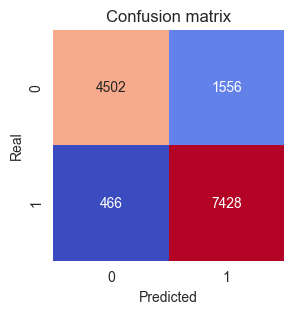

In [186]:
model_info(y_test, y_pred_lr)

In [230]:
joblib.dump(lr_model,'../models/LR_model_Serhii.pkl')

['../models/LR_model_Serhii.pkl']

### LinearSVC

In [ ]:
svc = LinearSVC(random_state=42)

svc_start_time = time.time()
param_grid = {
    'C': [1, 0.1, 0.01, 0.001, 0.0001], 
    'tol':[1e-3, 1e-4], 
    'max_iter':[25, 30, 35, 50], 
    'class_weight':[{0:0.3, 1:0.7}, {0:0.4, 1:0.6}],
    'loss':['hinge','squared_hinge'],
    'penalty':['l1', 'l2']
    }
linearSVC = GridSearchCV(svc, param_grid, cv=2, scoring=recall_1, verbose=0, n_jobs=-1)

linearSVC.fit(X_train, y_train)

svc_model = linearSVC.best_estimator_
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)
recall_svc = recall_score(y_test, y_pred_svc, pos_label=1)
precision_svc = precision_score(y_test, y_pred_svc, pos_label=1)

svc_end_time = time.time()-svc_start_time

In [189]:
print(f'LinearSVC best parameters: {linearSVC.best_params_}')
print(f'Build LinearSVC model time: {svc_end_time:.2f} secs')

LinearSVC best parameters: {'C': 0.0001, 'class_weight': {0: 0.3, 1: 0.7}, 'loss': 'hinge', 'max_iter': 25, 'penalty': 'l2', 'tol': 0.001}
Build LinearSVC model time: 26.94 secs


Модель прогнозує 1 у 79.91% випадках
На тестувальних данних правильно 94.05%  класу 1

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78      6058
           1       0.80      0.94      0.86      7894

    accuracy                           0.83     13952
   macro avg       0.85      0.82      0.82     13952
weighted avg       0.84      0.83      0.83     13952


 --------------------------------------------------


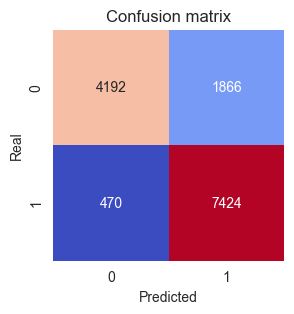

In [190]:
model_info(y_test, y_pred_svc)

In [229]:
joblib.dump(lr_model,'../models/LSVC_model_Serhii.pkl')

['../models/LSVC_model_Serhii.pkl']

### SVC RBF kernel

In [192]:
from sklearn.svm import SVC
SVC_rbf = SVC(random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 5],
    'kernel':['rbf'], 
    'class_weight':[{0:0.3, 1:0.7}]
    }
SVC_rbf = GridSearchCV(SVC_rbf, param_grid, cv=2, scoring=recall_1, n_jobs=-1, verbose=0)

SVC_rbf.fit(X_train, y_train)

svc_rbf_model = SVC_rbf.best_estimator_
svc_rbf_start_time = time.time()
svc_rbf_model.fit(X_train, y_train)
svc_rbf_end_time = time.time()-svc_rbf_start_time

y_pred_svc_rbf = svc_rbf_model.predict(X_test)
precision_svc_rbf = precision_score(y_test, y_pred_svc_rbf, pos_label=1)
recall_svc_rbf = recall_score(y_test, y_pred_svc_rbf, pos_label=1)

In [193]:
print(f'SVC best parameters: {SVC_rbf.best_params_}')
print(f'Build SVC model time: {svc_rbf_end_time:.2f} secs')

SVC best parameters: {'C': 0.01, 'class_weight': {0: 0.3, 1: 0.7}, 'kernel': 'rbf'}
Build SVC model time: 221.85 secs


##### Статистика роботи моделі SVC rbf  на тестувальних данних 

Модель прогнозує 1 у 82.78% випадках
На тестувальних данних правильно 94.44%  класу 1

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      6058
           1       0.83      0.94      0.88      7894

    accuracy                           0.86     13952
   macro avg       0.87      0.84      0.85     13952
weighted avg       0.86      0.86      0.85     13952


 --------------------------------------------------


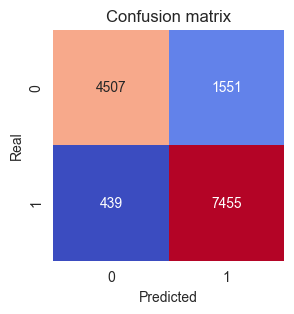

In [194]:
model_info(y_test, y_pred_svc_rbf)

Гарні результати після 18 хвилин підбору параметрів

In [228]:
joblib.dump(svc_rbf_model,'../models/SVC_rbf_model_Serhii.pkl')

['../models/SVC_rbf_model_Serhii.pkl']

----

### RandomForest

In [195]:
RF = RandomForestClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 300],
    'max_features': [0.5, 1, 'sqrt'],
    'class_weight':[{0:0.3, 1:0.7}, 'balanced']
    }
RandomForest = GridSearchCV(estimator=RF, param_grid=param_grid, scoring=recall_1, refit=True, cv=2, n_jobs=-1, verbose=5)
RandomForest.fit(X_train, y_train)

rf_model = RandomForest.best_estimator_
rf_start_time = time.time()
rf_model.fit(X_train, y_train)
rf_end_time = time.time()-rf_start_time

y_pred_rf = rf_model.predict(X_test)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
precision_rf = precision_score(y_test, y_pred_rf, pos_label=1)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


In [211]:
print(f'RandomForest best parameters: {RandomForest.best_params_}')
print(f'Build RandomForest model time: {rf_end_time:.2f} secs')

RandomForest best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 0.5, 'n_estimators': 300}
Build RandomForest model time: 63.54 secs


##### Статистика роботи моделі на тестувальних данних

Модель прогнозує 1 у 95.89% випадках
На тестувальних данних правильно 93.70%  класу 1

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      6058
           1       0.96      0.94      0.95      7894

    accuracy                           0.94     13952
   macro avg       0.94      0.94      0.94     13952
weighted avg       0.94      0.94      0.94     13952


 --------------------------------------------------


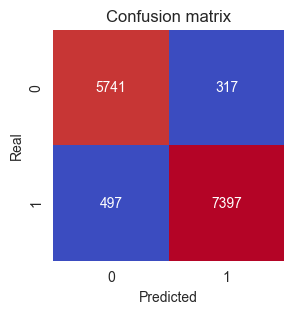

In [208]:
model_info(y_test, y_pred_rf)

#### Отримаємо чудовий результат. Мінімальна помилка в обох класах.

In [231]:
joblib.dump(rf_model,'../models/RF_model_Serhii.pkl', compress=3)

['../models/RF_model_Serhii.pkl']

##### Важливість ознак в датасеті для отриманої моделі

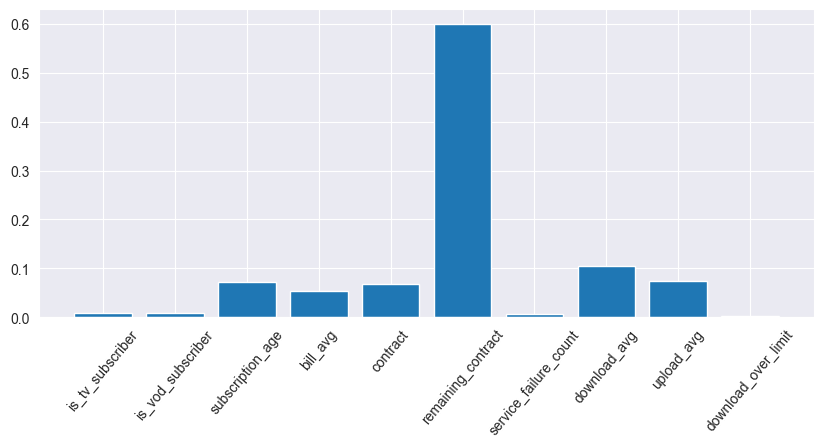

In [199]:
plt.figure(figsize=(10,4))
plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.xticks(range(len(df.columns[1:-1])), df.columns[1:-1], rotation=50);

----

### Basic Neural Network

##### Побудуємо просту нейронну мережу.  
Розмірність данних змінемо за допомогою MinMaxScaler

In [200]:
min_max_scaler = MinMaxScaler()

min_max_scaler.fit_transform(x_train)
X_train_nn = min_max_scaler.transform(x_train)
X_test_nn = min_max_scaler.transform(x_test)

In [201]:
y_train_nn = y_train.to_numpy()
y_test_nn = y_test.to_numpy()
type(y_train_nn)

numpy.ndarray

In [202]:
model_NN = Sequential()
model_NN.add(Dense(128, input_dim=10, activation='relu'))
model_NN.add(BatchNormalization())
model_NN.add(Dropout(0.25))
model_NN.add(Dense(64, activation='relu'))
model_NN.add(BatchNormalization())
model_NN.add(Dropout(0.25))
model_NN.add(Dense(1, activation='sigmoid'))

model_NN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.Recall(name='recall_nn')])
model_NN.summary()

nn_start_time = time.time()
# early_stopping = EarlyStopping(monitor='val_recall_nn', patience=5)
history = model_NN.fit(X_train_nn, y_train_nn, epochs=40, batch_size=64, validation_split=0.1, class_weight={0:0.3, 1:0.7})

score = model_NN.evaluate(X_test_nn, y_test_nn, verbose=0)

y_pred_nn = model_NN.predict(X_test_nn)

nn_end_time = time.time()-nn_start_time

c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,497 (41.00 KB)

 Trainable params: 10,113 (39.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1715 - recall_nn: 0.9034 - val_loss: 0.2593 - val_recall_nn: 0.9349
Epoch 2/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1181 - recall_nn: 0.9330 - val_loss: 0.2353 - val_recall_nn: 0.9349
Epoch 3/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1123 - recall_nn: 0.9291 - val_loss: 0.2328 - val_recall_nn: 0.9367
Epoch 4/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1091 - recall_nn: 0.9292 - val_loss: 0.2280 - val_recall_nn: 0.9361
Epoch 5/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1082 - recall_nn: 0.9289 - val_loss: 0.2309 - val_recall_nn: 0.9364
Epoch 6/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1061 - recall_nn: 0.9312 - val_loss: 0.2400 - val_recall_nn: 0.9373
Epoch 7/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1052 - recall_nn: 0.9311 - val_loss: 0.2346 - val_recall_nn: 0.9392
Epoch 8/40
785/785 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1045 - recall_nn: 0.9338 - v

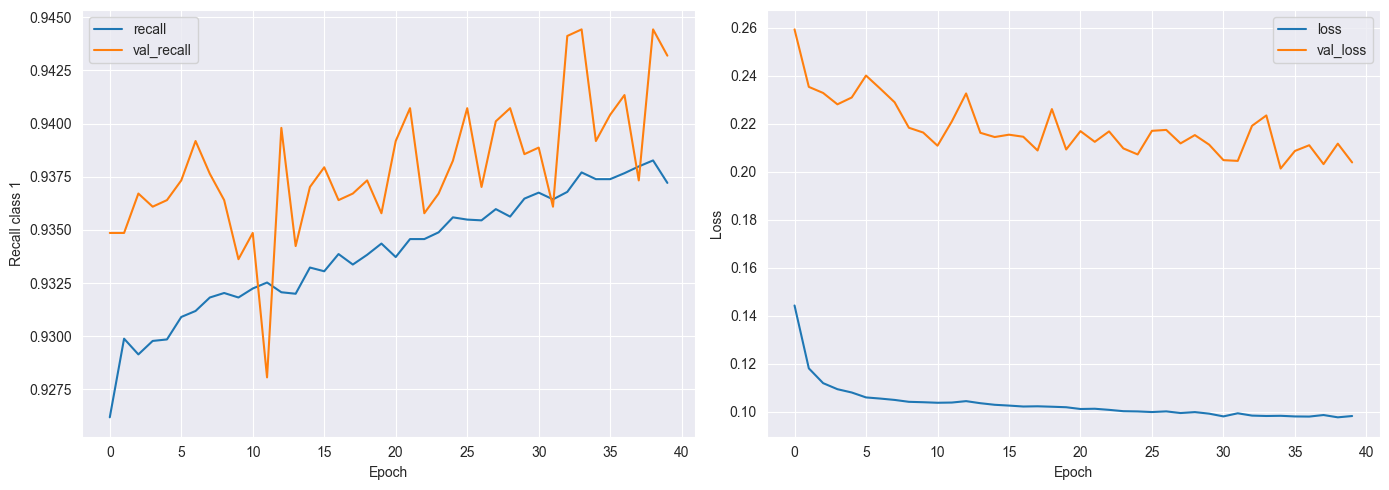

In [203]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['recall_nn'], label='recall')
plt.plot(history.history['val_recall_nn'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall class 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Статистика роботи моделі на тестувальних данних

Модель прогнозує 1 у 93.76% випадках
На тестувальних данних правильно 94.21%  класу 1

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6058
           1       0.94      0.94      0.94      7894

    accuracy                           0.93     13952
   macro avg       0.93      0.93      0.93     13952
weighted avg       0.93      0.93      0.93     13952


 --------------------------------------------------


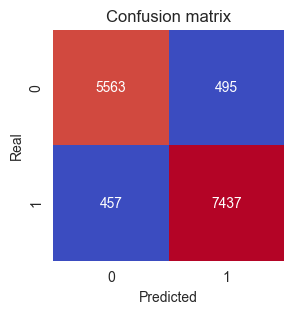

In [204]:
binary_predictions = [1 if p > 0.5 else 0 for p in y_pred_nn]
recall_nn = recall_score(y_test_nn, binary_predictions, pos_label=1)
precision_nn = precision_score(y_test_nn, binary_predictions, pos_label=1)
model_info(y_test, binary_predictions)

Збережемо модель та скейлер

In [226]:
joblib.dump(model_NN,'../models/NN_model_Serhii.pkl')
joblib.dump(min_max_scaler,'../scalers/NN_scaler_Serhii.pkl')

['../scalers/NN_scaler_Serhii.pkl']

### Порівняємо роботу різних моделей

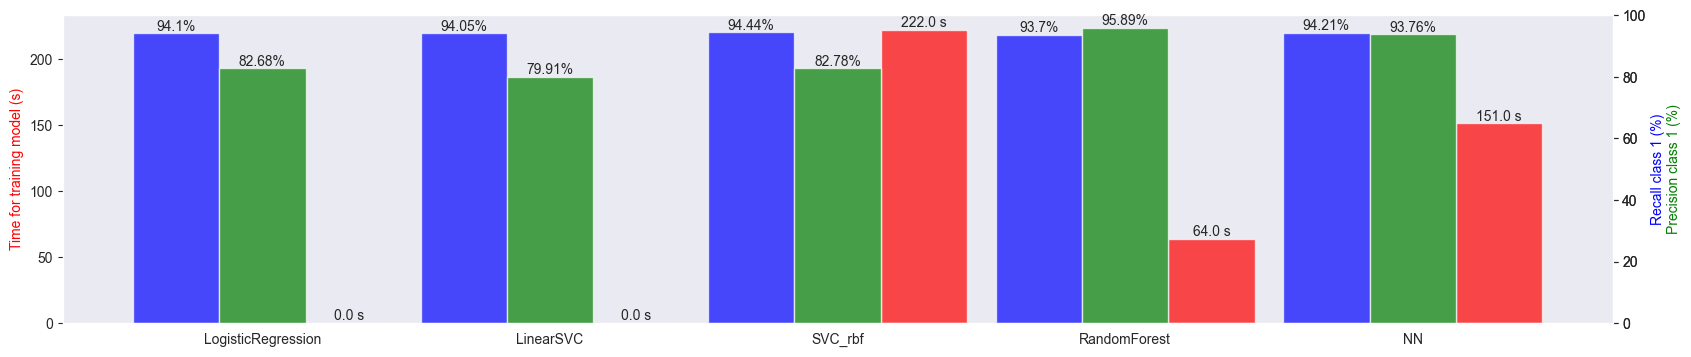

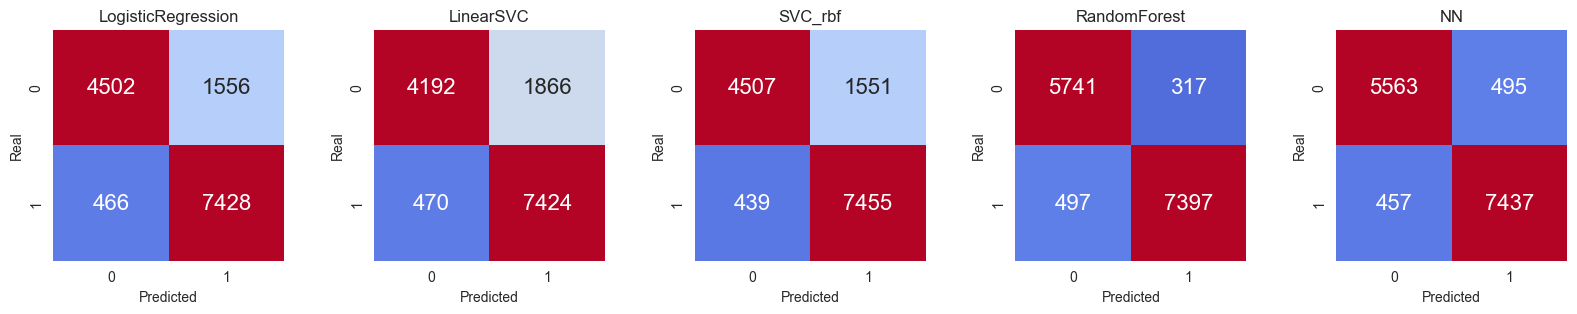

In [225]:
data = {'model':['LogisticRegression','LinearSVC', 'SVC_rbf', 'RandomForest', 'NN'],
        'analyze_time':[lr_end_time, lr_end_time, svc_rbf_end_time, rf_end_time ,nn_end_time],
        'recall':[recall_lr*100, recall_svc*100, recall_svc_rbf*100, recall_rf*100, recall_nn*100],
        'precision':[precision_lr*100, precision_svc*100, precision_svc_rbf*100, precision_rf*100, precision_nn*100],
        'y_pred':[y_pred_lr, y_pred_svc, y_pred_svc_rbf, y_pred_rf, binary_predictions]
        }

df_results = pd.DataFrame(data)

fig, ax= plt.subplots(figsize=(20, 4))
ax2 = ax.twinx()
ax3 = ax.twinx()
width = 0.3

x = np.array([i for i,_ in enumerate(df_results['model'])])

ax.bar(x + width, df_results['analyze_time'], color='r', alpha=0.7, width=width)
ax2.bar(x - width, df_results['recall'], color='b', alpha=0.7, width=width)
ax3.bar(x, df_results['precision'], color='g', alpha=0.7, width=width)

plt.xticks(range(len(df_results['model'])), df_results['model'], rotation=0);

ax.set_ylabel('Time for training model (s)', color='r')
ax2.set_ylabel('Recall class 1 (%)', color='b')
ax3.set_ylabel('\nPrecision class 1 (%)', color='g')

ax3.set_ylim([0, 100])
ax2.set_ylim([0, 100])
ax.grid(False)
ax2.grid(False)
ax3.grid(False)

for i, v in enumerate(df_results['analyze_time'].round()):
    ax.text(i+0.3, v, str(v)+' s', ha='center', va='bottom')

for i, v in enumerate(df_results['recall'].round(2)):
    ax2.text(i-0.3, v, str(v)+'%', ha='center', va='bottom')

for i, v in enumerate(df_results['precision'].round(2)):
    ax3.text(i, v, str(v)+'%', ha='center', va='bottom')

plt.show()


plt.figure(figsize=(20, 3))
for i, (m, p) in enumerate(zip(df_results['model'], df_results['y_pred'])):
    cm = confusion_matrix(y_test, p)
    plt.subplot(1, 5, i+1)
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=0, vmax=4200, annot_kws={"size": 16})
    plt.title(m)
    plt.ylabel('Real')
    plt.xlabel('Predicted')
plt.show()